In [1]:
%matplotlib inline

import cv2
import time
import numpy as np
import csv
import os
import imutils
from matplotlib import pyplot as plt

In [4]:
# load image data
folder_path = 'Images/DepthImage'
file_prefix = 'frame_'

# Get a list of all files in the folder
files = os.listdir(folder_path)

# Filter the list to only include files with the desired prefix
matching_files = [f for f in files if f.startswith(file_prefix)]


# load ground truth data
csv_path = './Images/groundTruth.csv'

# Open the CSV file and read its contents into a list of tuples
with open(csv_path, 'r') as csvfile:
    reader = csv.reader(csvfile)
    centres = [tuple(row) for row in reader]


zipped = list(zip(matching_files, centres))
print(zipped)

[('frame_1686210461.jpg', ('307', '141')), ('frame_1686210465.jpg', ('391', '162')), ('frame_1686210469.jpg', ('467', '196')), ('frame_1686210472.jpg', ('257', '283')), ('frame_1686210478.jpg', ('351', '287')), ('frame_1686210483.jpg', ('437', '301')), ('frame_1686210486.jpg', ('511', '306')), ('frame_1686210490.jpg', ('261', '334')), ('frame_1686210494.jpg', ('344', '341')), ('frame_1686210497.jpg', ('483', '355'))]


In [5]:
def houghTransform(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    maskDataRGB = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    blurredCircles = cv2.GaussianBlur(img, (5, 5), 0)
    thresholdCircles = cv2.inRange(
            blurredCircles, 15, 25)
    # plt.imshow(thresholdCircles)
    # Perform Hough Transform for circles
    circles = cv2.HoughCircles(
            thresholdCircles, cv2.HOUGH_GRADIENT, 2, minDist=700, param1=50, param2=30, minRadius=10, maxRadius=30)
    if not circles.any():
        return []
    # Round the x,y coordinates and radius to integers
    circles = np.round(circles[0, :]).astype("int")
    # Calculate centroids using Hough Transform
    centroids_hough = [(x, y) for (x, y, r) in circles]
    for center in centroids_hough:
        cv2.circle(maskDataRGB, center, 5, (0, 0, 255), -1)
        cv2.circle(maskDataRGB, center, 30, (0, 0, 255), 2)
    plt.imshow(maskDataRGB)
    return centroids_hough
    

In [6]:
def blobDetection(img_path):
    # Read the image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Create a blob detector
    params = cv2.SimpleBlobDetector_Params()

    # Set parameters for the blob detection
    params.minThreshold = 10
    params.maxThreshold = 100
    params.filterByCircularity = False
    params.filterByConvexity = False
    params.filterByInertia = False
    params.filterByArea = True
    params.minArea = 100
    params.maxArea = 10000

    # Create a blob detector with the specified parameters
    detector = cv2.SimpleBlobDetector_create(params)

    # Detect blobs in the image
    keypoints = detector.detect(img)

    # Create an RGB image for visualization
    maskDataRGB = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Draw circles around the detected blobs
    for keypoint in keypoints:
        x, y = np.round(keypoint.pt).astype(int)
        cv2.circle(maskDataRGB, (x, y), 5, (0, 0, 255), -1)
        cv2.circle(maskDataRGB, (x, y), 30, (0, 0, 255), 2)
    # Extract centroids from keypoints
    centroids_blob = [(int(keypoint.pt[0]), int(keypoint.pt[1])) for keypoint in keypoints]

    return centroids_blob


In [7]:
def contourDetection(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    blurredCircles = cv2.GaussianBlur(img, (5, 5), 0)
    thresholdCircles = cv2.inRange(
            blurredCircles, 15, 25)
    # find contours 
    contoursObject = cv2.findContours(thresholdCircles, cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)

    contoursObject = imutils.grab_contours(contoursObject)

    maskDataRGB = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    centres = []
    # remove contours that are the wrong size
    for i in range(len(contoursObject)-1, -1, -1):
        ((x, y), radius) = cv2.minEnclosingCircle(
            contoursObject[i])
        if radius < 15:
            del contoursObject[i]
        else:
            M = cv2.moments(contoursObject[i])
            centre = (int(M["m10"] / M["m00"]),
                        int(M["m01"] / M["m00"]))
            centres.append(centre)
            # draw the contours we are interested in
            cv2.circle(maskDataRGB, (int(x), int(y)), int(radius),
                    (0, 255, 255), 2)
            cv2.circle(maskDataRGB, centre, 5, (0, 0, 255), -1)
        
    # plt.imshow(maskDataRGB)
    return centres

In [8]:
def improvedContours(img_path):
    # obtain the filtered circles
    filteredData = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    blurredCircles = cv2.GaussianBlur(filteredData, (5, 5), 0)
    thresholdCircles = cv2.inRange(
            blurredCircles, 15, 25)
    # perform dilations and erosions to remove small blobs left in the mask
    maskCircles = cv2.erode(
        thresholdCircles, None, iterations=2)

    # find contours in the mask and initialize the current
    # (x, y) centre of the ball
    contoursObject = cv2.findContours(maskCircles.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    contoursObject = imutils.grab_contours(contoursObject)

    maskDataRGB = cv2.cvtColor(maskCircles, cv2.COLOR_GRAY2RGB)
    centres = []
    # remove contours that are the wrong size
    for i in range(len(contoursObject)-1, -1, -1):
        ((x, y), radius) = cv2.minEnclosingCircle(
            contoursObject[i])
        if radius < 15  or radius > 20:
            del contoursObject[i]
        else:
            M = cv2.moments(contoursObject[i])
            centre = (int(M["m10"] / M["m00"]),
                        int(M["m01"] / M["m00"]))
            centres.append(centre)
            # draw the contours we are interested in
            cv2.circle(maskDataRGB, (int(x), int(y)), int(radius),
                    (0, 255, 255), 2)
            cv2.circle(maskDataRGB, centre, 5, (0, 0, 255), -1)
    # plt.imshow(maskDataRGB)
    return centres

In [9]:
def evaluate(zipped, prefix):
    mse_hough_total = 0
    hough_time = 0
    mse_moments_total = 0
    moments_time = 0
    mse_improved_moments_total = 0
    improved_moments_time = 0
    num_items = len(zipped)
    for img_details in zipped:
        img_path = prefix+img_details[0]
        ground_truth = np.array([int(x) for x in img_details[1]])
        # Calculate centroids
        start_time = time.time()
        centroids_hough = houghTransform(img_path)
        hough_time+=(time.time() - start_time)
        start_time = time.time()
        centroids_moments = contourDetection(img_path)
        moments_time+=(time.time() - start_time)
        start_time = time.time()
        centroids_improved_moments = improvedContours(img_path)
        improved_moments_time+=(time.time() - start_time)
        # Compute the mean squared error between the two methods
        mse_hough = np.mean(np.square(np.array(centroids_hough) - ground_truth))
        mse_moments = np.mean(np.square(np.array(centroids_moments) - ground_truth))
        mse_improved_moments= np.mean(np.square(np.array(centroids_improved_moments) - ground_truth))

        mse_hough_total+=mse_hough
        mse_moments_total+=mse_moments
        mse_improved_moments_total+=mse_improved_moments
        
    hough_time /= num_items
    moments_time /= num_items
    improved_moments_time /= num_items
    mse_hough_total /= num_items
    mse_moments_total /= num_items
    mse_improved_moments_total /= num_items

    print("Evaluation metrics: ")
    print("Hough: ", mse_hough_total, "px in ", hough_time, "s")
    print("Moments: ", mse_moments_total, "px in ", moments_time, "s")
    print("Improved Moments: ", mse_improved_moments_total, "px in ", improved_moments_time, "s")

Evaluation metrics: 
Hough:  26071.25 px in  0.015631866455078126 s
Moments:  33872.191666666666 px in  0.004710340499877929 s
Improved Moments:  5932.95 px in  0.0034954071044921873 s


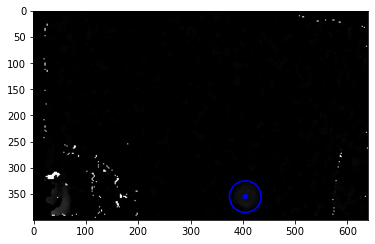

In [10]:
evaluate(zipped, "Images/DepthImage/")